In [1]:
# python required >= 3.5 version
import sys
assert sys.version_info >=(3,5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

import numpy as np
import os
import pandas as pd
# make the output satable accros run
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

ROOT = "."
chapter_id = "DNN"
image_path = os.path.join(ROOT,"images",chapter_id)
os.makedirs(image_path,exist_ok=True)

def save_fig(fig_id,tigh_layout=True,fig_extension="png",resolution=300):
    path = os.path.join(image_path,fig_id + "." + fig_extension)
    print("save figure ",fig_id)
    if tigh_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)


In [2]:
# get dataset fashion_mnist dataset
(X_train_full,y_train_full),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()
# standarisasi train data
X_train_full = X_train_full/255.0

# split train data to train and validasi data
X_valid,X_train = X_train_full[:5000], X_train_full[5000:]
y_valid,y_train = y_train_full[:5000], y_train_full[5000:]

# l1 and l2 regulazation

In [3]:
layer = keras.layers.Dense(100,activation="elu",
                           kernel_initializer = "he_normal",
                           kernel_regularizer=keras.regularizers.l2(1e-2))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [4]:
model_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300,activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(1e-2)),
    
    keras.layers.Dense(100,activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(1e-2)),

    keras.layers.Dense(10,activation="softmax",
                       kernel_initializer="glorot_uniform",
                       kernel_regularizer=keras.regularizers.l2(1e-2))
    
])

In [5]:
model_1.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model_1.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6140 - accuracy: 0.7779 - val_loss: 0.9429 - val_accuracy: 0.7826
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9084 - accuracy: 0.7945 - val_loss: 0.8814 - val_accuracy: 0.8082


pada saat program diatas terjadi boiler code pengulangan berapa layer yang sama dapat di hilangkan dengan simple menggunakan from functools import partial

In [6]:
from functools import partial
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(1e-2))
    

In [7]:
model_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    # RegularizedDense(10, activation="softmax",kernel_initializer="glorot_uniform")
    keras.layers.Dense(10, activation="softmax",kernel_initializer="glorot_uniform")
])
model_2.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model_2.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3936 - accuracy: 0.7827 - val_loss: 0.7617 - val_accuracy: 0.7990
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6911 - accuracy: 0.8108 - val_loss: 0.6406 - val_accuracy: 0.8288


In [8]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               235500    
                                                                 
 dense_5 (Dense)             (None, 100)               30100     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


# Regular Dropout

In [9]:
y_train.max()

9

In [10]:
tf.random.set_seed(42)
np.random.seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_09_07-12_33_11'

In [11]:
model_3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(rate=2e-1),
    keras.layers.Dense(300,activation="elu",kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=2e-1),
    keras.layers.Dense(100,activation="elu",kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate=2e-1),
    keras.layers.Dense((y_train.max()+1),activation="softmax",kernel_initializer="glorot_normal")
    
])

model_3.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.Nadam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999),
                metrics=["accuracy"])
n_epochs=5
per_lr_sc = keras.callbacks.ReduceLROnPlateau(factor=5e-1, patience=5)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
check_point = keras.callbacks.ModelCheckpoint("droput_reguler.h5",save_best_only=True)
history_3 = model_3.fit(X_train,y_train,epochs=n_epochs,
                        validation_data = [X_valid,y_valid],
                        callbacks=[per_lr_sc,tensorboard_cb,check_point]) 

Epoch 1/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5783 - accuracy: 0.7895 - val_loss: 0.4410 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4558 - accuracy: 0.8312 - val_loss: 0.3554 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4207 - accuracy: 0.8425 - val_loss: 0.3758 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 4/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3996 - accuracy: 0.8515 - val_loss: 0.3383 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3841 - accuracy: 0.8568 - val_loss: 0.3227 - val_accuracy: 0.8774 - lr: 0.0010


In [27]:
%load_ext tensorboard 
%tensorboard --logdir=./my_logs --port=6006


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2340), started 4 days, 14:58:32 ago. (Use '!kill 2340' to kill it.)

# Alpha droput 
for used to selu, if used regular dropout ill break the self normalized scaled. used aplha dropout to drop the neuron on layer have self normalized scaled

In [13]:
model_4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.AlphaDropout(rate=2e-1),
    keras.layers.Dense(300,activation="selu",kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=2e-1),
    keras.layers.Dense(100,activation="selu",kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=2e-1),
    keras.layers.Dense((max(y_train)+1),activation="softmax",kernel_initializer="glorot_normal")
    
])
optimizer_sgd= keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizer_nadam=keras.optimizers.Nadam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999,)
model_4.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer_sgd,
                metrics=["accuracy"])
per_lr_sc = keras.callbacks.ReduceLROnPlateau(factor=5e-1, patience=5)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
check_point = keras.callbacks.ModelCheckpoint("droput_alpha.h5",save_best_only=True)
model_4.fit(X_train,y_train,epochs=20,
            validation_data =[X_valid,y_valid],
            callbacks=[per_lr_sc,tensorboard_cb,check_point])

Epoch 1/20
1719/1719 [==============================] - 5s 2ms/step - loss: 1.0667 - accuracy: 0.5985 - val_loss: 0.9514 - val_accuracy: 0.7046 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9113 - accuracy: 0.6569 - val_loss: 0.9581 - val_accuracy: 0.6986 - lr: 0.0100
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.8853 - accuracy: 0.6675 - val_loss: 0.8460 - val_accuracy: 0.7290 - lr: 0.0100
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8714 - accuracy: 0.6726 - val_loss: 0.7937 - val_accuracy: 0.7296 - lr: 0.0100
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8518 - accuracy: 0.6811 - val_loss: 0.8418 - val_accuracy: 0.7296 - lr: 0.0100
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8395 - accuracy: 0.6835 - val_loss: 0.8943 - val_accuracy: 0.7168 - lr: 0.0100
Epoch 7/20
1719/1719 [==============================] - 4s

In [14]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2340), started 4 days, 14:50:41 ago. (Use '!kill 2340' to kill it.)

# MC Dropout
use to stack the prediction to get uncertainly result

In [85]:
model_5 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(rate=2e-1),
    keras.layers.Dense(300,activation="elu",kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=2e-1),
    keras.layers.Dense(100,activation="elu",kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate=2e-1),
    keras.layers.Dense((y_train.max()+1),activation="softmax",kernel_initializer="glorot_normal")
    
])

model_5.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.Nadam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999),
                metrics=["accuracy"])
n_epochs=5
per_lr_sc = keras.callbacks.ReduceLROnPlateau(factor=5e-1, patience=5)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
check_point = keras.callbacks.ModelCheckpoint("MCdroput_reguler.h5",save_best_only=True)
history_5 = model_5.fit(X_train,y_train,epochs=n_epochs,
                        validation_data = [X_valid,y_valid],
                        callbacks=[per_lr_sc,tensorboard_cb,check_point])

Epoch 1/5
1719/1719 [==============================] - 7s 3ms/step - loss: 0.5783 - accuracy: 0.7895 - val_loss: 0.4410 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4558 - accuracy: 0.8312 - val_loss: 0.3554 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4207 - accuracy: 0.8425 - val_loss: 0.3758 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 4/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3996 - accuracy: 0.8515 - val_loss: 0.3383 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 5/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3841 - accuracy: 0.8568 - val_loss: 0.3227 - val_accuracy: 0.8774 - lr: 0.0010


In [103]:
tf.random.set_seed(42)
np.random.seed(42)

y_probas = np.stack([model_5(X_test,training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [104]:
pd.DataFrame(np.round(y_proba[:,:1],2)).to_csv("MC_dropout.csv")

In [105]:
np.round(y_probas[:,:1],2)

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0.,

In [106]:
# if we used aplha or normal droput
np.round(model_3.predict(X_test[:1]), 2)

1/1 [==============================] - 0s 23ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [107]:
np.round(y_proba[:1],2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],
      dtype=float32)

In [108]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.1 , 0.  , 0.14]],
      dtype=float32)

In [109]:
y_pred = np.argmax(y_proba, axis=1)

In [110]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8081

Menggunakan sebuah MCDroput class

In [111]:
class MCDropout(keras.layers.Dropout):
    def call(self,inputs):
        return super().call(inputs,training=True)
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self,inputs):
        return super().call(inputs,training=True)#keras.layers.Dropout.call

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

In [119]:
model_4.layers

# if the model that was already trained using Dropout

In [94]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model_4.layers
])

In [95]:
mc_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_10 (Dense)            (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_11 (Dense)            (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)             

In [113]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2,momentum=9e-1,nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
                 metrics="accuracy")

In [114]:
model_4.get_weights()

[array([[ 0.03548559,  0.03596996, -0.02094203, ..., -0.08629905,
          0.01452116, -0.01742492],
        [-0.01290158, -0.01174875,  0.00278806, ..., -0.0059267 ,
          0.01220075, -0.00251674],
        [ 0.01920423, -0.0143154 , -0.00542587, ...,  0.01512135,
         -0.01877172, -0.00390337],
        ...,
        [-0.00633549, -0.01025443,  0.03679189, ..., -0.01629214,
          0.0573898 , -0.02476463],
        [ 0.05038016, -0.02357397, -0.03637261, ..., -0.01246104,
          0.10953466, -0.00357981],
        [-0.01056041, -0.00884356, -0.02200292, ..., -0.05694712,
          0.05932778,  0.03236826]], dtype=float32),
 array([-0.09780677,  0.0252364 , -0.08063976,  0.19999324, -0.56334144,
         0.06075104, -0.30795258, -0.7711903 , -0.55438495, -0.32417473,
        -0.0661072 , -0.6286108 ,  0.03059398, -0.08950458, -0.12498669,
         0.21305485,  0.06876744, -0.43755803, -0.15678614,  0.10176112,
        -0.5766948 , -0.12125414,  0.01366713, -0.19575456, -0.212

In [115]:
mc_model.set_weights(model_4.get_weights())

In [120]:
np.round(np.mean([mc_model.predict(X_test[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 13ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [122]:
model_5.layers

In [123]:
mc_model_reguler = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer,keras.layers.Dropout) else layer
    for layer in model_5.layers
])

In [125]:
mc_model_reguler.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 300)               235500    
                                                                 
 mc_dropout_1 (MCDropout)    (None, 300)               0         
                                                                 
 dense_20 (Dense)            (None, 100)               30100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_21 (Dense)            (None, 10)               

In [126]:
optimizer= keras.optimizers.SGD(learning_rate=1e-2,momentum=9e-1,nesterov=True)
mc_model_reguler.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
                         metrics=["accuracy"])

In [127]:
# get the replatika weights from model_5
mc_model_reguler.set_weights(model_5.get_weights())

In [129]:
mc_model_reguler.get_weights()

[array([[-0.05362086, -0.0356145 ,  0.05663493, ..., -0.04749006,
         -0.12657492, -0.01936427],
        [ 0.00577461,  0.04256564,  0.17320378, ..., -0.06068274,
         -0.0706283 ,  0.01298249],
        [-0.00149281,  0.03326672,  0.190233  , ..., -0.23597048,
         -0.00627826,  0.03828293],
        ...,
        [-0.04404194, -0.02841009, -0.29065868, ...,  0.10024995,
         -0.06882864, -0.01195874],
        [-0.16808364, -0.07951536, -0.17380613, ..., -0.11039361,
         -0.0554599 , -0.1058711 ],
        [ 0.02747711, -0.01965584, -0.27240288, ..., -0.06313697,
         -0.04422575, -0.01412545]], dtype=float32),
 array([ 0.01537779, -0.02392881, -0.05823087, -0.05802429, -0.24798986,
        -0.03404561,  0.04054422,  0.07564765,  0.02593856,  0.08589066,
        -0.15132304,  0.09127526,  0.01520403, -0.11699631,  0.09705026,
         0.30258128,  0.17590651,  0.06699632,  0.13472556,  0.03443019,
         0.01466569, -0.3129682 ,  0.06711738, -0.08267906, -0.075

In [131]:
#training stack MC Dropout
np.round(np.mean([mc_model_reguler.predict(X_test[:1]) for reguler in range(1000)],axis=0),2)

1/1 [==============================] - 0s 13ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

# Max norm

In [136]:
layer = keras.layers.Dense(100,activation="selu",
                           kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [137]:
Max_Norm_Dense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

In [140]:
model_6 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    Max_Norm_Dense(300),
    Max_Norm_Dense(100),
    keras.layers.Dense(10,activation="softmax")
])
model_6.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
per_lr_sc = keras.callbacks.ReduceLROnPlateau(factor=5e-1, patience=5)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
check_point = keras.callbacks.ModelCheckpoint("MCdroput_reguler.h5",save_best_only=True)

history_6 = model_6.fit(X_train,y_train,epochs=n_epochs,
                        validation_data = [X_valid,y_valid],
                        callbacks=[per_lr_sc,tensorboard_cb,check_point])

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4992 - accuracy: 0.8181 - val_loss: 0.4730 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3974 - accuracy: 0.8543 - val_loss: 0.3533 - val_accuracy: 0.8722 - lr: 0.0010


In [141]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2340), started 4 days, 16:33:49 ago. (Use '!kill 2340' to kill it.)

# Sumary
Recommend arsitektur

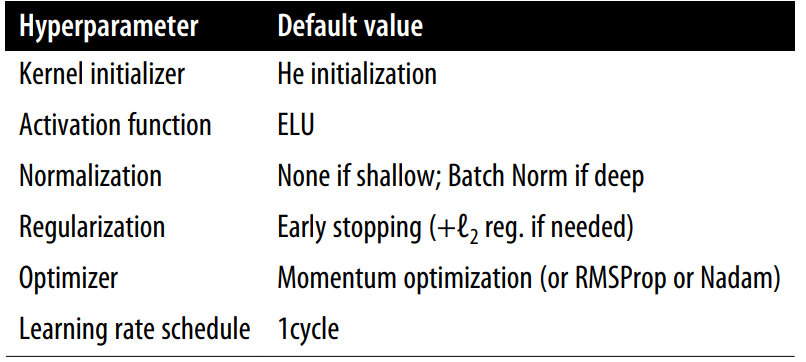

In [143]:
# For normal layer
from IPython.display import Image
Image("images\DNN\Summary_normal.PNG")

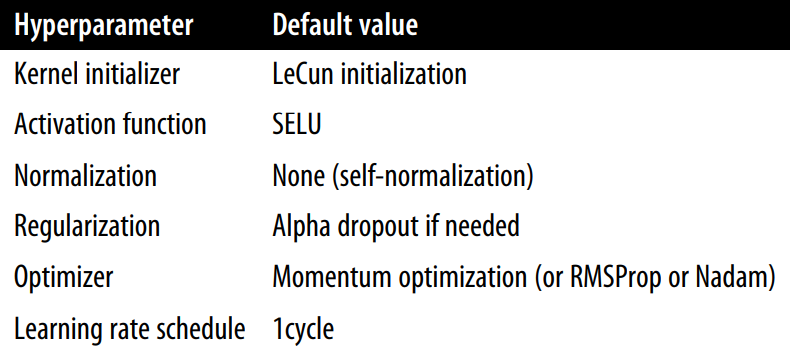

In [144]:
# for self normalized layer arsitektur
from IPython.display import Image
Image("images\DNN\Sumary_self normalized.PNG")